# JaxTOuNN

In this notebook we seek to implement TOuNN using Jax. The program is end-end differentiable. This includes the FE solver that has previously been outside the computation chain.

Aaditya Chandrasekhar
UW Madison
achandrasek3@wisc.edu

### Imports

In [24]:
# We begin by importing the necessary libraries
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, random, jacfwd, value_and_grad
from jax.ops import index, index_add, index_update
from jax.experimental import stax, optimizers
from functools import partial
import jax.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

rand_key = random.PRNGKey(0); # reproducibility

### Mesh

For illustration and simplicity, we only consider simple rectangular meshes in the implementation.

In [25]:
nelx, nely = 40, 20;
elemSize = np.array([1., 1.])
mesh = {'ndim':2, 'nelx':nelx, 'nely':nely, 'elemSize':elemSize,\
        'ndof':2*(nelx+1)*(nely+1), 'numElems':nelx*nely};

In [26]:
# Next we populate the domain with points. 
# These points are processed by the NN
def generatePointsInsideDomain(mesh, res = 1):
  # args: Mesh is dictionary containing nelx, nely, elemSize...
  # res is the number of points per elem
  # returns an array of size (numpts X 2)
  xy = np.zeros((res*mesh['nelx']*res*mesh['nely'],2));
  ctr = 0;
  for i in range(res*mesh['nelx']):
    for j in range(res*mesh['nely']):
      xy[ctr,0] = (i + 0.5)/(res*mesh['elemSize'][0]);
      xy[ctr,1] = (j + 0.5)/(res*mesh['elemSize'][1]);
      ctr += 1;
  return xy;

In [27]:
# observe that xyElems is an array from jax. 
# This makes tracking the variable possible
xyElems = jnp.array(generatePointsInsideDomain(mesh));
print(xyElems.shape)

(800, 2)


In [28]:
# with the mesh sprecified, we can now calc 
# info wrt connectivity and node numbering
def getMeshStructure(mesh):
  # returns edofMat: array of size (numElemsX8) with 
  # the global dof of each elem
  # idx: A tuple informing the position for assembly of computed entries 
  edofMat=np.zeros((mesh['nelx']*mesh['nely'],8),dtype=int)
  for elx in range(mesh['nelx']):
    for ely in range(mesh['nely']):
      el = ely+elx*mesh['nely']
      n1=(mesh['nely']+1)*elx+ely
      n2=(mesh['nely']+1)*(elx+1)+ely
      edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2,\
                      2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])
  iK = tuple(np.kron(edofMat,np.ones((8,1))).flatten().astype(int))
  jK = tuple(np.kron(edofMat,np.ones((1,8))).flatten().astype(int))
  idx = jax.ops.index[iK,jK]
  return edofMat, idx
#-----------------------#
def getBMatrix(mesh, xi, eta):
  dx, dy = mesh['elemSize'][0], mesh['elemSize'][1];
  B = np.zeros((3,8));
  r1 = np.array([(2.*(eta/4. - 1./4.))/dx, -(2.*(eta/4. - 1./4))/dx,\
                  (2.*(eta/4. + 1./4))/dx,\
                  -(2.*(eta/4. + 1./4))/dx]).reshape(-1);
  r2 = np.array([(2.*(xi/4. - 1./4))/dy, -(2.*(xi/4. + 1./4))/dy,\
                  (2.*(xi/4. + 1./4))/dy, -(2.*(xi/4. - 1./4))/dy])
  
  B = [[r1[0], 0., r1[1], 0., r1[2], 0., r1[3], 0.],\
        [0., r2[0], 0., r2[1], 0., r2[2], 0., r2[3]],\
        [r2[0], r1[0], r2[1], r1[1], r2[2], r1[2], r2[3], r1[3]]];

  return jnp.array(B)

In [29]:
edofMat, idx = getMeshStructure(mesh)
B = getBMatrix(mesh, 0., 0.) # eval B matrix at elem center

### Material

In [30]:
#Next we define the relevant material property. 
# We are concerned only with structural mech
# at the moment. penal here refers to the SIMP penalization constant
material = {'Emax':1., 'Emin':1e-3, 'nu':0.3, 'penal':1.}

In [31]:
# with the material defined, we can now calculate the base constitutive matrix
def getD0(material):
  # the base constitutive matrix assumes unit 
  #area element with E = 1. and nu prescribed.
  # the material is also assumed to be isotropic.
  # returns a matrix of size (8X8)
  E = 1.
  nu = material['nu'];
  k = np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,\
                  -1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
  KE = \
  E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
  [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
  [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
  [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
  [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
  [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
  [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
  [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
  return KE;

In [32]:
  material['D0'] = getD0(material);

### BC

In [33]:
# Next we get the BCs for the problem.
# We encode the BC for some standard probs in examples.py 
# eg 1- tipcant , 2-midcant, 3- MBB, 4- Michell, 5-DistributedBeam

# bc is a dictionary with keys
#['exampleName', 'force', 'fixed', 'symXAxis', 'symYAxis']

example = 1;
nelx, nely = mesh['nelx'], mesh['nely']
if(example == 1): # tip cantilever
  ndof = 2*(nelx+1)*(nely+1);
  force = np.zeros((ndof,1))
  dofs=np.arange(ndof);
  fixed = dofs[0:2*(nely+1):1];
  free = jnp.setdiff1d(np.arange(mesh['ndof']),fixed);
  force[2*(nelx+1)*(nely+1)-2*nely+1, 0 ] = -1;
  symXAxis = False;
  symYAxis = False;
elif(example == 2): # mid cantilever
  ndof = 2*(nelx+1)*(nely+1);
  force = np.zeros((ndof,1))
  dofs=np.arange(ndof);
  fixed = dofs[0:2*(nely+1):1];
  free = jnp.setdiff1d(np.arange(mesh['ndof']),fixed);
  force[2*(nelx+1)*(nely+1)- (nely+1), 0 ] = -1;
  # force[int(2*nelx*(nely+1)/2)+1 ,0]= -10; # TEST- mid load
  symXAxis = True;
  symYAxis = False;
bc = {'force':force, 'fixed':fixed,'free':free,\
      'symXAxis':symXAxis, 'symYAxis':symYAxis};

### Symmetry

The resulting structure might be symmetric about an axis. However, owing to the nonlinearity of the NN this may not be enforced implicitly. We therefore explicitly enforce symmetry by transforming the coordinates


In [34]:
def imposeSymmetry(xy, mesh, bc):
  if(bc['symYAxis']):
    xv = jax.ops.index_update(xy[:,0],index[:], 0.5*mesh['nelx']\
                          + jnp.abs( xy[:,0] - 0.5*mesh['nelx']) );
  else:
    xv = xy[:,0]
  if(bc['symXAxis']):
    yv = jax.ops.index_update(xy[:,1],index[:], 0.5*mesh['nely']\
                          + jnp.abs( xy[:,1] - 0.5*mesh['nely']) );
  else:
    yv = xy[:,1]
  xy = jnp.stack((xv,yv)).T;
  return xy;

In [35]:
# transform the coordinates of the elem centres based on if symm is enforced by the prob.
xyElems = imposeSymmetry(xyElems, mesh, bc);

### Neural Network

In [36]:
# Let us now define the actual NN. We consider a fully connected NN
# with LeakyRelu as the activation and a sigmoid in the output layer
def elementwise(fun, **fun_kwargs):
    """Layer that applies a scalar function elementwise on its inputs."""
    init_fun = lambda rng, input_shape: (input_shape, ())
    apply_fun = lambda params, inputs, **kwargs: fun(inputs, **fun_kwargs)
    return init_fun, apply_fun
Swish = elementwise(nn.swish)

def makeNetwork(nnspec):
  # JAX network definition
  layers = []
  for i in range(nnspec['numLayers']-1):
    layers.append(stax.Dense(nnspec['numNeuronsPerLayer']))
    layers.append(Swish)#(stax.LeakyRelu)
  layers.append(stax.Dense(nnspec['outputDim']))
  layers.append(stax.Sigmoid)
  return stax.serial(*layers)

In [37]:
nnspec = {'outputDim':1, 'numNeuronsPerLayer':20,  'numLayers':2}

### FE Solver CM

We now turn our attention to defining functions that are needed for solving the system. We use jit to speed up the computation

In [38]:
class FESolver:
  def __init__(self, mesh, material, bc):
    self.mesh = mesh;
    self.bc = bc;
    self.material = material;
    self.objectiveHandle = jit(self.objective)
  #-----------------------# 
  def objective(self, Y):
    @jit
    def assembleK(Y):
      K = jnp.zeros((self.mesh['ndof'], self.mesh['ndof']));
      kflat_t = (self.material['D0'].flatten()[np.newaxis]).T 
      sK = (kflat_t*Y).T.flatten();
      K = jax.ops.index_add(K, idx, sK);
      return K;
    #-----------------------#
    @jit
    def solve(K):
      # eliminate fixed dofs for solving sys of eqns
      u_free = jax.scipy.linalg.solve(K[self.bc['free'],:][:,self.bc['free']], \
              self.bc['force'][self.bc['free']], sym_pos = True, check_finite=False);
      u = jnp.zeros((self.mesh['ndof']));
      u = jax.ops.index_add(u, self.bc['free'], u_free.reshape(-1)); # homog bc wherev fixed
      return u;
    #-----------------------#
    @jit
    def computeCompliance(K, u):
      J = jnp.dot(self.bc['force'].reshape(-1).T, u)
      return J
    #-----------------------#
    K = assembleK(Y);
    u = solve(K);
    J = computeCompliance(K, u);
    return J;

# Opt

### Projections

Input and output projections help us define among many geometric, manufacturing constraints.

In [39]:
#-------FOURIER LENGTH SCALE-----------#
def computeFourierMap(mesh, fourierMap):
  # compute the map
  coordnMapSize = (mesh['ndim'], fourierMap['numTerms']);
  freqSign = np.random.choice([-1.,1.], coordnMapSize)
  stdUniform = np.random.uniform(0.,1., coordnMapSize) 
  wmin = 1./(2*fourierMap['maxRadius']*mesh['elemSize'][0])
  wmax = 1./(2*fourierMap['minRadius']*mesh['elemSize'][0]) # w~1/R
  wu = wmin +  (wmax - wmin)*stdUniform;
  coordnMap = np.einsum('ij,ij->ij', freqSign, wu);
  return coordnMap;
#-----------------#
def applyFourierMap(xy, fourierMap):
  if(fourierMap['isOn']):
    c = jnp.cos(2*np.pi*jnp.einsum('ij,jk->ik', xyElems, fourierMap['map']))
    s = jnp.sin(2*np.pi*jnp.einsum('ij,jk->ik', xyElems, fourierMap['map']))
    xy = jnp.concatenate((c, s), axis = 1)
  return xy

### Optimization
Finally, we are now ready to express the optimization problem

In [40]:
# Optimization params
lossMethod = {'type':'penalty', 'alpha0':0.05, 'delAlpha':0.05};
#lossMethod = {'type':'logBarrier', 't0':3, 'mu':1.1};

fourierMap = {'isOn': True, 'minRadius':4., \
              'maxRadius':80., 'numTerms':  200};

fourierMap['map'] = computeFourierMap(mesh, fourierMap)


optimizationParams = {'maxEpochs':450, 'learningRate':0.01, 'desiredVolumeFraction':0.5,\
                     'lossMethod':lossMethod}

In [41]:
def optimizeDesign(xy, optParams, mesh, material, bc, fourierMap):
  FE = FESolver(mesh, material, bc)
  # input projection
  if(fourierMap['isOn']):
   xy = applyFourierMap(xy, fourierMap)
  # make the NN
  init_fn, applyNN = makeNetwork(nnspec);
  fwdNN = jit(lambda nnwts, x: applyNN(nnwts, x))
  _, params = init_fn(rand_key, (-1, xy.shape[1]))
  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(optParams['learningRate'])
  opt_state = opt_init(params)
  opt_update = jit(opt_update)
  
  # fwd once to get J0-scaling param
  density0  = fwdNN(get_params(opt_state), xy)
  J0 = FE.objectiveHandle(density0.reshape(-1))

  def getYoungsModulus(density):
    material['penal'] = min(8., 1. + epoch*0.02)
    Y = material['Emin'] + \
          (material['Emax']-material['Emin'])*(density+0.001)**material['penal']
    return Y
  #-----------------------#
  # loss function
  def computeLoss(nnwts):
    density  = 0.01 + fwdNN(nnwts, xy)
    Y = getYoungsModulus(density)
    volcons = (jnp.mean(density)/optParams['desiredVolumeFraction'])- 1.
    J = FE.objectiveHandle(Y.reshape(-1))

    if(optParams['lossMethod']['type'] == 'penalty'):
      alpha = optParams['lossMethod']['alpha0'] + \
              epoch*optParams['lossMethod']['delAlpha']; # penalty method
      loss = J/J0 + alpha*volcons**2;
    if(optParams['lossMethod']['type'] == 'logBarrier'):
      t = optParams['lossMethod']['t0']* \
                        optParams['lossMethod']['mu']**epoch;
      if(volcons < (-1/t**2)):
        psi = -jnp.log(-volcons)/t;
      else:
        psi = t*volcons - jnp.log(1/t**2)/t + 1/t;
      loss = J/J0 + psi;

    return loss;
  
  # optimization loop
  for epoch in range(optParams['maxEpochs']):
    opt_state = opt_update(epoch, \
                optimizers.clip_grads(jax.grad(computeLoss)(get_params(opt_state)), 1.),\
                opt_state)

    if(epoch%10 == 0):
      density = fwdNN(get_params(opt_state), xy)
      Y = getYoungsModulus(density)
      J = FE.objectiveHandle(Y.reshape(-1))
      volf= jnp.mean(density)
      if(epoch == 10):
        J0 = J;
      status = 'epoch {:d}, J {:.2E}, vf {:.2F}'.format(epoch, J/J0, volf);
      print(status)
      if(epoch%30 == 0):
        plt.figure();
        plt.imshow(-jnp.flipud(density.reshape((nelx, nely)).T),\
                  cmap='gray')
        plt.title(status)
        plt.show();

  return fwdNN, get_params(opt_state)

# Run

epoch 0, J 8.49E-02, vf 0.37


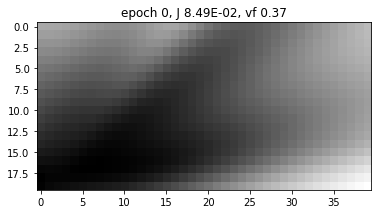

epoch 10, J 1.00E+00, vf 0.56
epoch 20, J 8.89E-01, vf 0.59
epoch 30, J 7.85E-01, vf 0.66


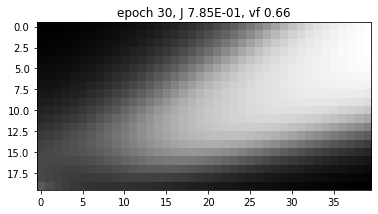

epoch 40, J 8.99E-01, vf 0.62
epoch 50, J 9.26E-01, vf 0.62
epoch 60, J 8.95E-01, vf 0.64


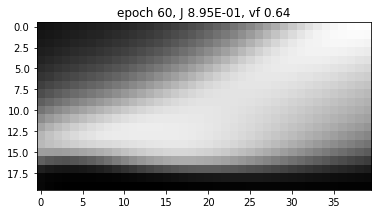

epoch 70, J 9.97E-01, vf 0.62
epoch 80, J 1.23E+00, vf 0.57
epoch 90, J 1.06E+00, vf 0.63


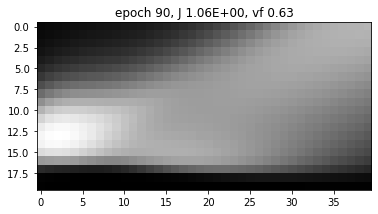

epoch 100, J 1.27E+00, vf 0.59
epoch 110, J 1.22E+00, vf 0.61
epoch 120, J 1.33E+00, vf 0.58


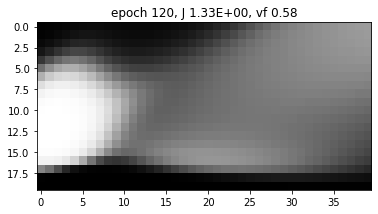

epoch 130, J 1.13E+00, vf 0.62
epoch 140, J 1.54E+00, vf 0.55
epoch 150, J 1.28E+00, vf 0.59


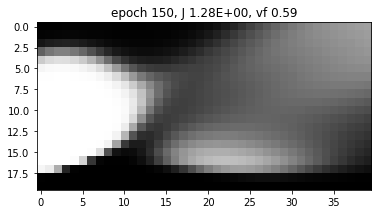

epoch 160, J 1.41E+00, vf 0.56
epoch 170, J 1.24E+00, vf 0.58
epoch 180, J 1.55E+00, vf 0.53


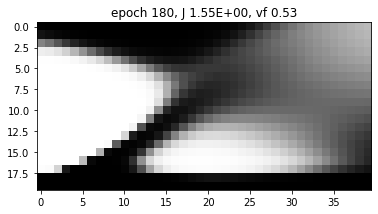

epoch 190, J 1.25E+00, vf 0.55
epoch 200, J 1.26E+00, vf 0.55
epoch 210, J 1.26E+00, vf 0.52


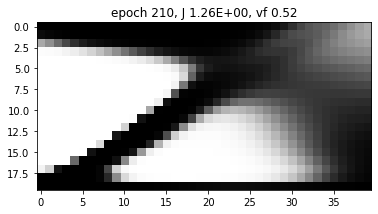

epoch 220, J 1.26E+00, vf 0.52
epoch 230, J 1.28E+00, vf 0.52
epoch 240, J 1.23E+00, vf 0.51


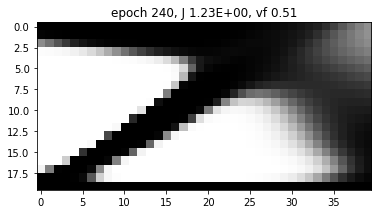

epoch 250, J 1.05E+00, vf 0.57
epoch 260, J 1.44E+00, vf 0.50
epoch 270, J 1.11E+00, vf 0.53


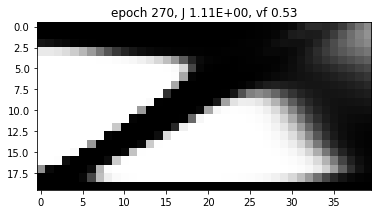

epoch 280, J 1.13E+00, vf 0.52
epoch 290, J 1.02E+00, vf 0.54
epoch 300, J 1.06E+00, vf 0.51


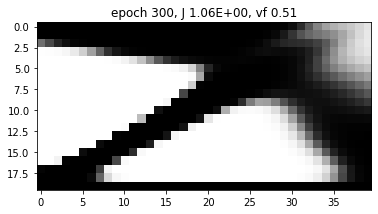

epoch 310, J 1.01E+00, vf 0.53
epoch 320, J 1.03E+00, vf 0.50
epoch 330, J 9.76E-01, vf 0.53


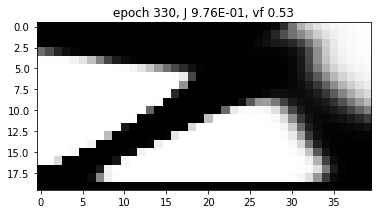

epoch 340, J 9.68E-01, vf 0.53
epoch 350, J 1.03E+00, vf 0.49
epoch 360, J 1.04E+00, vf 0.48


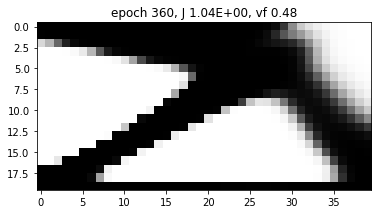

epoch 370, J 1.03E+00, vf 0.49
epoch 380, J 1.10E+00, vf 0.48
epoch 390, J 9.61E-01, vf 0.52


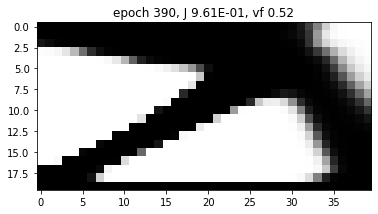

epoch 400, J 1.01E+00, vf 0.49
epoch 410, J 9.41E-01, vf 0.51
epoch 420, J 9.76E-01, vf 0.49


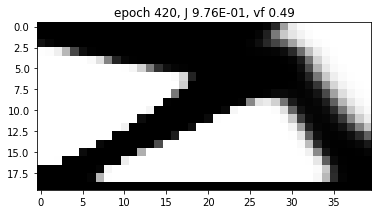

epoch 430, J 9.29E-01, vf 0.51
epoch 440, J 9.68E-01, vf 0.49


In [42]:
network, nnwts = optimizeDesign(xyElems, optimizationParams, mesh, material, bc, fourierMap)